# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## Import Libraries

In [1]:
# python libraries
import os, sys
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
import pandas as pd
from sklearn import decomposition, svm, preprocessing
from sklearn.utils import class_weight
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics
from keras.utils import to_categorical
from keras.models import load_model
from tensorflow.python.client import device_lib

# custom libraries
# base_dir = '/Users/cyrilwendl/Documents/EPFL'
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package

from helpers.helpers import *
from helpers.plots import *
from helpers.data_augment import *
from helpers.data_loader import *
from helpers.parameter_search import *
from density_forest.density_forest import *
from density_forest.helpers import *
from baselines.helpers import *
from keras_helpers.unet import *
from keras_helpers.callbacks import *

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # sys.argv[2]
print(device_lib.list_local_devices())

class_to_remove = 8  # int(sys.argv[1])
paramsearch = True  # search for best hyperparameters

my_dpi=255 # dpi of my screen, for image exporting

# data frame with previously found optimal hyperparameters
df_ps = pd.read_csv('models_out/hyperparams.csv', index_col=0) 

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2729507151768799553
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10919205274
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6445340632797153900
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


# Load Data

In [2]:
path = os.getcwd()

# data without overlap
print("loading data")
data_train = ZurichLoader(path, 'train', class_to_remove=class_to_remove)
data_val = ZurichLoader(path, 'val', class_to_remove=class_to_remove)
data_test = ZurichLoader(path, 'test', class_to_remove=class_to_remove)

print("loading data with overlap")
# data with overlap, for prediction
data_train_overlap = ZurichLoader(path, 'train', stride=32, inherit_loader=data_train)
data_val_overlap = ZurichLoader(path, 'val', stride=32, inherit_loader=data_val)
data_test_overlap = ZurichLoader(path, 'test', stride=32, inherit_loader=data_test)

# class names and colors
names = data_train.names
colors = data_train.colors
n_classes = 8
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

loading data
loading data with overlap
classes to keep: ['Buildings' 'Trees' 'Grass' 'Bare Soil' 'Water' 'Railways']


In [3]:
for dataset, offset in zip([data_train, data_val, data_test], [0, 10, 15]):
    for im_idx, im in enumerate(dataset.imgs):
        im = im[..., :3]
        f_name = "../Figures/Zurich/Im/Im_" + str(im_idx + offset) + ".jpg"
        export_figure_matplotlib(im, f_name, dpi=my_dpi)

In [4]:
for dataset, offset in zip([data_train, data_val, data_test], [0, 10, 15]):
    for gt_idx, gt in enumerate(dataset.gt):
        gt_col = gt_label_to_color(gt, colors)*255
        f_name = "../Figures/Zurich/Im/GT_" + str(gt_idx + offset) + ".jpg"
        export_figure_matplotlib(gt_col, f_name, dpi=my_dpi)

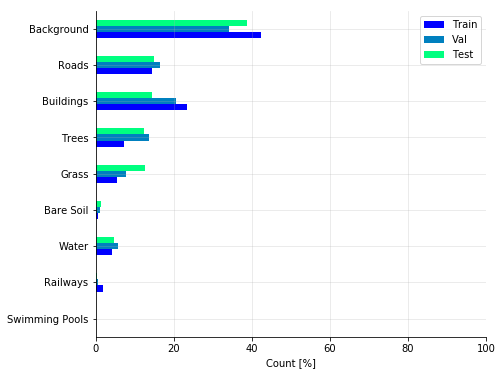

In [5]:
pred_labels_tr, cnt_tr = np.unique(data_train.gt_patches, return_counts=True)
pred_labels_val, cnt_val = np.unique(data_val.gt_patches, return_counts=True)
pred_labels_te, cnt_te = np.unique(data_test.gt_patches, return_counts=True)

cnt_tr = cnt_tr / np.sum(cnt_tr) * 100
cnt_val = np.concatenate((cnt_val / np.sum(cnt_val) * 100, [0]))
cnt_te = cnt_te / np.sum(cnt_te) * 100

df = pd.DataFrame({'Train': cnt_tr, 'Val': cnt_val, 'Test': cnt_te}, index=names[pred_labels_tr])

axis = df[::-1].plot.barh(figsize=(7, 6), colormap='winter')
plt.xlim([0, 100])
plt.xlabel("Count [%]")
plt.grid(alpha=.3)
axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)
plt.savefig("../Figures/Zurich/Pred_count/ZH_dist.pdf", bbox_inches='tight', pad_inches=0)

# CNN Training

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [6]:
"""
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))
"""

'\n# create copies of original data\ny_train_label = y_train.copy()\ny_val_label = y_val.copy()\ny_test_label = y_test.copy()\n\n# get class weights\nlabels_unique = np.unique(y_train.flatten())\nprint(labels_unique)\nclass_weights = class_weight.compute_class_weight(\'balanced\', labels_unique, y_train.flatten())\nclass_weights[0] = 0  # give less weight to background label class\nclass_weights[5] = 7  # give less weight to bare soil class\nclass_weights[8] = 7  # give less weight to swimming pool class\n\nprint("Class weights:")\nfor i, w in enumerate(class_weights):\n    print("%15s: %3.3f" % (names[i], w))\n'

In [7]:
"""

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))
"""

'\n\n# convert to numpy arrays\nx_train = np.asarray(x_train)\nx_val = np.asarray(x_val)\nx_test = np.asarray(x_test)\n\n# make y data categorical\ny_train = to_categorical(y_train_label, n_classes)\ny_val = to_categorical(y_val_label, n_classes)\n\ny_train = y_train[..., classes_to_keep]\ny_val = y_val[..., classes_to_keep]\nn_classes = len(classes_to_keep)\nclass_weights = class_weights[classes_to_keep]\n\n# print shapes of variables\nfor var in x_train, y_train, x_val, y_val:\n    print(np.shape(var))\n'

### Train CNN

In [8]:
"""
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   # callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)
                        
"""

'\n# callbacks (evaluated every epoch)\n# show loss and accuracy figures after each epoch\ncallback_plot = PlotLosses()\n\n# stop early if after several epochs the accuracy doesn\'t improve\ncallback_earlystop = EarlyStopping(monitor=\'val_loss\', min_delta=1e-4, patience=24, verbose=1, mode=\'auto\')\n\n# decrease learning rate when accuracy stops improving\ncallback_lr = ReduceLROnPlateau(monitor=\'val_loss\', factor=0.5, patience=12, verbose=1, mode=\'auto\',\n                                epsilon=1e-4, cooldown=0, min_lr=1e-8)\n\n# checkpoint to save weights at every epoch (in case of interruption)\nfile_path = "weights-improvement.hdf5"\ncallback_checkpoint = ModelCheckpoint(file_path, monitor=\'val_acc\', verbose=0, save_best_only=True, mode=\'max\')\n\ncallback_tensorboard = TensorBoard(log_dir=\'./tensorboard\', histogram_freq=0, write_graph=True, write_images=True)\n\n# model setup\nbatch_size = 20\nepochs = 300\n\n\ndef model_train(model, data_augmentation):\n    # Fit the 

In [9]:
# train or load model
# train the model
# model_unet = get_unet(n_classes, x_train.shape[1:])
# model_train(model_unet, data_augmentation=True)
# model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [10]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower().replace(" ", "") + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### Predictions

In [11]:
# get all predictions in training and test set
# training set
y_pred_tr = model_unet.predict(data_train_overlap.im_patches, verbose=1)
y_pred_tr = np.concatenate(remove_overlap(data_train.imgs, y_pred_tr, np.arange(10), 64, 32))
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=class_to_remove, background=True)

# validation set
y_pred_val = model_unet.predict(data_val_overlap.im_patches, verbose=1)
y_pred_val = np.concatenate(remove_overlap(data_val.imgs, y_pred_val, np.arange(5), 64, 32))
y_pred_label_val = get_y_pred_labels(y_pred_val, class_to_remove=class_to_remove, background=True)

# test set
y_pred_te = model_unet.predict(data_test_overlap.im_patches, verbose=1)
y_pred_te = np.concatenate(remove_overlap(data_test.imgs, y_pred_te, np.arange(5), 64, 32))
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=class_to_remove, background=True)

4740/4740 [==============================] - 3s 562us/step


In [12]:
# get indices of correctly / incorrectly predicted pixels
# train
#pred_t_tr = (data_train.gt_patches != class_to_remove) & (data_train.gt_patches != 0)
pred_t_tr = y_pred_label_tr == data_train.gt_patches
pred_f_tr = data_train.gt_patches == class_to_remove

# val
#pred_t_val = (data_val.gt_patches != class_to_remove) & (data_val.gt_patches != 0)
pred_t_val = y_pred_label_val == data_val.gt_patches
pred_f_val = data_val.gt_patches == class_to_remove

# test
#pred_t_te = (data_test.gt_patches != class_to_remove) & (data_test.gt_patches != 0)
pred_t_te = y_pred_label_te == data_test.gt_patches
pred_f_te = data_test.gt_patches == class_to_remove

In [13]:
# export predicted images
offset = 0
for dataset, preds in zip([data_train, data_val, data_test], [y_pred_label_tr, y_pred_label_val, y_pred_label_te]):
    for im_idx in range(len(dataset.imgs)):
        im = convert_patches_to_image(dataset.imgs, preds[..., np.newaxis], im_idx, 64, 64, 0)[..., 0]
        im_color = gt_label_to_color(im, colors) * 255
        f_name = "../Figures/Zurich/Im_pred/cl_" + str(class_to_remove)
        f_name = f_name + "/Im_" + str(im_idx + offset) + "_wo_cl_" + str(class_to_remove) + ".jpg"
        export_figure_matplotlib(im_color, f_name, dpi=my_dpi)
        
    offset += len(dataset.imgs)

### Accuracy Metrics (Test Set)

In [14]:
# Get oa, aa for train, val, test
# train
y_pred_tr_flattened = np.asarray(y_pred_label_tr.flatten()).astype('int')
y_tr_flattened = np.asarray(data_train.gt_patches.flatten()).astype('int')
filter_items = (y_tr_flattened != 0) & (y_tr_flattened != class_to_remove)
oa_tr = oa(y_tr_flattened[filter_items], y_pred_tr_flattened[filter_items])
aa_tr, aa_tr_cl = aa(y_tr_flattened[filter_items], y_pred_tr_flattened[filter_items])

# val
y_pred_val_flattened = np.asarray(y_pred_label_val.flatten()).astype('int')
y_val_flattened = np.asarray(data_val.gt_patches.flatten()).astype('int')
filter_items = (y_val_flattened != 0) & (y_val_flattened != class_to_remove)
oa_val = oa(y_val_flattened[filter_items], y_pred_val_flattened[filter_items])
aa_val, aa_val_cl = aa(y_val_flattened[filter_items], y_pred_val_flattened[filter_items])

# test
y_pred_te_flattened = np.asarray(y_pred_label_te.flatten()).astype('int')
y_te_flattened = np.asarray(data_test.gt_patches.flatten()).astype('int')
filter_items = (y_te_flattened != 0) & (y_te_flattened != class_to_remove)
oa_te = oa(y_te_flattened[filter_items], y_pred_te_flattened[filter_items])
aa_te, aa_te_cl = aa(y_te_flattened[filter_items], y_pred_te_flattened[filter_items])

print(np.round(np.multiply([oa_tr, aa_tr], 100), 2))
print(np.round(np.multiply([oa_val, aa_val], 100), 2))
print(np.round(np.multiply([oa_te, aa_te], 100), 2))

[93.68 90.03]
[91.78 80.38]
[87.92 76.38]


In [15]:
# write metrics to CSV files
df_metrics = pd.read_csv('models_out/metrics_ND.csv', index_col=0)
df2 = pd.DataFrame({str(names[class_to_remove]):[oa_tr, aa_tr, oa_val, aa_val, oa_te, aa_te]},
                    index = ['OA Train', 'AA Train', 'OA Val', 'AA Val', 'OA Test', 'AA Test']).T
df_metrics = df_metrics.append(df2)
df_metrics = df_metrics[~df_metrics.index.duplicated(keep='last')]  # avoid duplicates
df_metrics.to_csv('models_out/metrics_ND.csv')
# print((df_metrics*100).round(2).to_latex())

In [16]:
# Accuracy metrics
y_pred_flattened = np.asarray(y_pred_label_te.flatten()).astype('int')
y_test_flattened = np.asarray(data_test.gt_patches.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
print(np.round(oa_te * 100, 2))

/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 7, does not match size of target_names, 6
  .format(len(labels), len(target_names))


             precision    recall  f1-score   support

  Buildings      0.829     0.978     0.897    698275
      Trees      0.888     0.876     0.882    603174
      Grass      0.954     0.830     0.888    616207
  Bare Soil      0.879     0.724     0.794     67038
      Water      0.981     0.870     0.922    234163
   Railways      0.051     0.085     0.064     18526

avg / total      0.886     0.879     0.879   2247769

87.92


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Distribution of predictions in unseen class

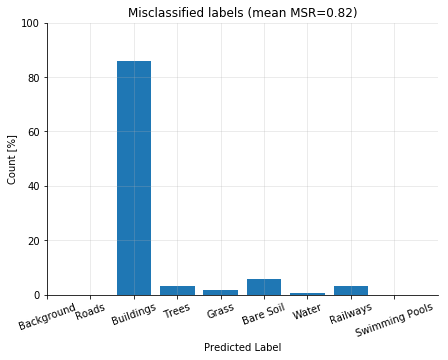

In [17]:
# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label_te[pred_f_te], return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0,100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(y_pred_te[pred_f_te])))
plt.xticks(pred_labels_te, names, rotation=20)
plt.savefig("../Figures/Zurich/Pred_count/ZH_pred-count_wo_cl" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

# Novelty Detection

## Network

In [18]:
# precision-recall curves

# msr
y_scores = (-get_acc_net_msr(y_pred_te)).flatten()
y_true = pred_f_te.flatten()
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (-get_acc_net_max_margin(y_pred_te)).flatten()
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (-get_acc_net_entropy(y_pred_te)).flatten()
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_msr, pr_auc_msr))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_margin, pr_auc_margin))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_entropy, pr_auc_entropy))

AUROC: 0.59, PR AUC: 0.18
AUROC: 0.58, PR AUC: 0.17
AUROC: 0.61, PR AUC: 0.19


In [19]:
# visualization
# MSR
probas_patches_msr = np.reshape((get_acc_net_msr(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# margin
probas_patches_margin = np.reshape((get_acc_net_max_margin(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# entropy
probas_patches_entropy = np.reshape((get_acc_net_entropy(y_pred_te)).flatten(), np.shape(data_test.gt_patches))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

base_folder = "../Figures/Zurich/Im_cert/cl_" + str(class_to_remove)

In [20]:

# export images
for img_idx in range(len(data_test.imgs)):
    im = data_test.imgs[img_idx]
    
    # msr
    acc_im_msr = convert_patches_to_image(data_test.imgs, probas_patches_msr[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_msr = exposure.equalize_hist(acc_im_msr)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_msr_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_msr, f_name, dpi=my_dpi)
    
    # margin
    acc_im_margin = convert_patches_to_image(data_test.imgs, probas_patches_margin[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_margin = exposure.equalize_hist(acc_im_margin)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_margin_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_margin, f_name, dpi=my_dpi)
    
    # entropy
    acc_im_entropy = convert_patches_to_image(data_test.imgs, probas_patches_entropy[..., np.newaxis],
                                              img_idx, 64, 64, 0)
    acc_im_entropy = exposure.equalize_hist(acc_im_entropy)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_entropy_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_entropy, f_name, dpi=my_dpi)

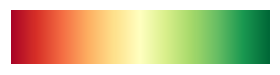

In [21]:
# export colorbar
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="RdYlGn")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.1, 0.4, 0.5])
cb = plt.colorbar(orientation="horizontal", cax=cax)
cb.outline.set_linewidth(0)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("../Figures/Zurich/Im_cert/colorbar.pdf", bbox_inches='tight', pad_inches=0)

## Dropout

In [22]:
# get predictions
y_preds = predict_with_dropout_imgs(model_unet, data_test_overlap.im_patches,
                                    data_test.imgs, np.arange(len(data_test.imgs)), batch_size=500,
                                    n_iter=10)

100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


In [23]:
# get prediction and confidence
prediction = np.mean(y_preds, 0)
probas_dropout = -get_acc_net_entropy(prediction)
del y_preds # free memory

In [24]:
# dropout metrics
y_scores = probas_dropout.flatten()
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

AUROC: 0.58, PR AUC: 0.17


In [25]:
# visualization
probas_patches_dropout = np.reshape(probas_dropout, np.shape(data_test.gt_patches))
probas_patches_dropout -= np.min(probas_patches_dropout)
probas_patches_dropout /= np.max(probas_patches_dropout)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(data_test.imgs)):
    acc_im_dropout = convert_patches_to_image(data_test.imgs, -probas_patches_dropout[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_dropout = exposure.equalize_hist(acc_im_dropout)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_dropout_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_dropout, f_name, dpi=my_dpi)

## Retrieve Activations, PCA, t-SNE

In [26]:
# get activations for training Density Forest
act_train_all = get_activations_batch(model_unet, -2, data_train_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_train_all = np.concatenate(remove_overlap(data_train.imgs, act_train_all, np.arange(len(data_train.imgs)), patch_size=64, stride=32))
act_train = act_train_all[pred_t_tr]

100%|██████████| 725/725 [00:13<00:00, 55.39it/s]


In [27]:
# get activations
act_val_all = get_activations_batch(model_unet, -2, data_val_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_val_all = np.concatenate(remove_overlap(data_val.imgs, act_val_all, np.arange(len(data_val.imgs)),
                                            patch_size=64, stride=32))
act_val = act_val_all[pred_t_val]

100%|██████████| 235/235 [00:02<00:00, 81.39it/s]


In [28]:
# get activations for testing Density Forest
act_test = get_activations_batch(model_unet, -2, data_test_overlap.im_patches, 20, verbose=True)

# remove test activations overlap
act_test = remove_overlap(data_test.imgs, act_test, np.arange(len(data_test.imgs)), patch_size=64, stride=32)
act_test = np.concatenate(np.concatenate(np.concatenate(act_test)))

100%|██████████| 237/237 [00:02<00:00, 84.60it/s]


In [29]:
# get balanced data subset to show in figure
tsne_pts_per_class = 200
dataset_subset_indices = get_balanced_subset_indices(data_test.gt_patches.flatten(), 
                                                     np.arange(1, 9), pts_per_class=tsne_pts_per_class)
dataset_subset_indices = np.concatenate(dataset_subset_indices)

In [30]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
tsne_y = data_test.gt_patches.flatten()[dataset_subset_indices]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.003s...
[t-SNE] Computed neighbors for 1600 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 1.054983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.746914
[t-SNE] Error after 500 iterations: 0.484053


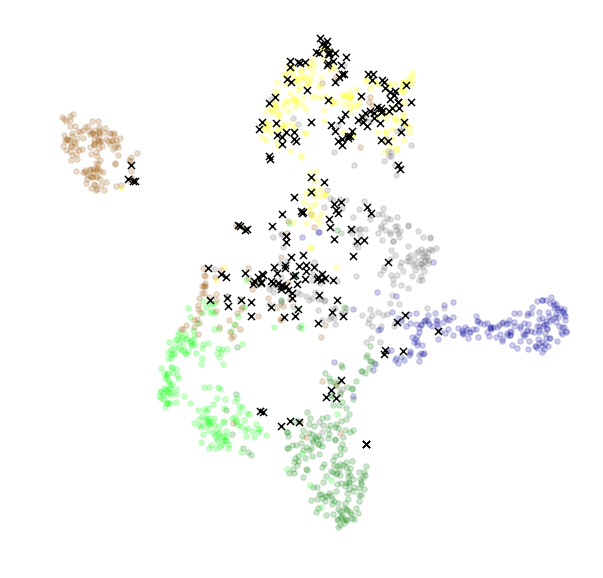

In [31]:
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors, class_to_remove=class_to_remove)
plt.savefig("../Figures/Zurich/tSNE/t-SNE_" + str(names[class_to_remove]).lower().replace(" ", "") + "_before_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

In [32]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(act_test)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train_all = pca.transform(np.concatenate(np.concatenate(act_train_all)))
act_train = pca.transform(act_train)

act_val_all = pca.transform(np.concatenate(np.concatenate(act_val_all)))
act_val = pca.transform(act_val)


# transform test set activations
act_test = pca.transform(act_test)

Variance explained by first 5 components: 0.96


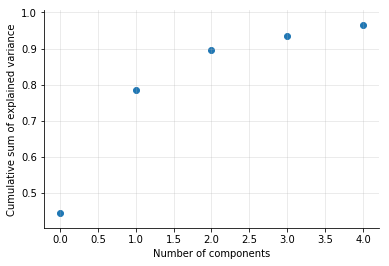

In [33]:
# Plot cumulative explained variance
fig = plt.figure()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.savefig("../Figures/Zurich/PCA/ZH_pca_components_wo_cl_" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [34]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
# tsne without unseen class
tsne_train = tsne_all[tsne_y != class_to_remove]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.938272
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.435425
[t-SNE] Error after 500 iterations: 0.460074


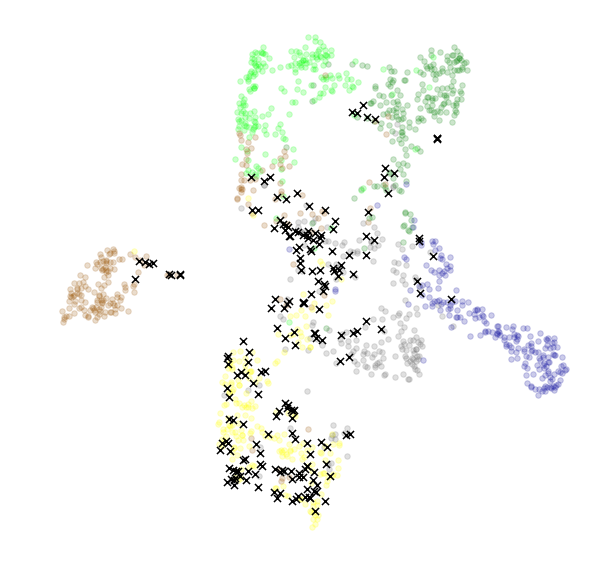

In [35]:
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors, class_to_remove=class_to_remove)
ax.set_axis_off()
plt.savefig("../Figures/Zurich/tSNE/t-SNE_" + str(names[class_to_remove]).lower().replace(" ", "") + "_after_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

Variance explained by first 3 components: 0.90


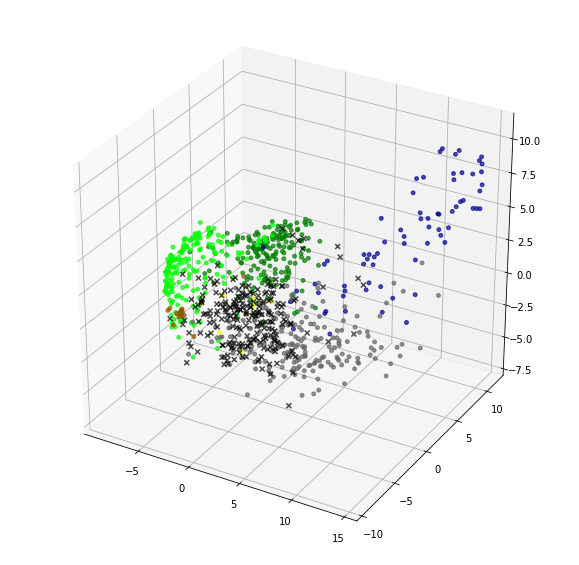

In [36]:
# plot first 3 PCA components
plot_pts_3d(act_test[:, :3], data_test.gt_patches.flatten(), classes_to_keep, colors,
            class_to_remove=class_to_remove, subsample_pct=.0003,
            s_name='../Figures/Zurich/PCA/pca_components_3d_' + str(names[class_to_remove]) + '.pdf')

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Variance explained by first 2 components: 0.78


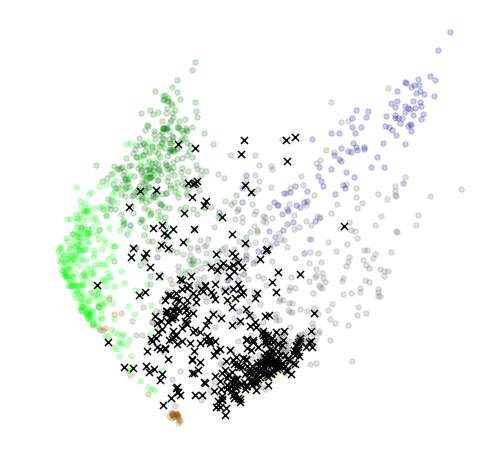

In [37]:
# plot first 2 PCA components
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
plot_pts_2d(act_test[:, :2], data_test.gt_patches.flatten(), ax, classes_to_keep, colors,
            class_to_remove=class_to_remove, subsample_pct=.0005,
            s_name='../Figures/Zurich/PCA/pca_components_2d_' + str(names[class_to_remove]) + '.pdf')
print("Variance explained by first 2 components: %.2f" % np.sum(pca.explained_variance_ratio_[:2]))

## GMM

In [38]:
best_degrees = [3, 5, 4, 3, 9, 5, 9, 3]

if paramsearch:
    tuned_parameters = [{'n_components': np.arange(3, 10), 'max_iter': [10000]}]
    # do parameter search
    ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, act_train, act_train_all,
                             pred_f_tr.flatten(), scorer_roc_probas_gmm, 
                             n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.01)
    ps_gmm.fit()
    best_params_gmm = ps_gmm.best_params
else:
    best_params_gmm = {'n_components': df_ps.loc[str(names[class_to_remove])]['gmm_n_components'], 'max_iter': 10000}
print(best_params_gmm)

Trying parameters: {'max_iter': 10000, 'n_components': 3}
Trying parameters: {'max_iter': 10000, 'n_components': 4}
Trying parameters: {'max_iter': 10000, 'n_components': 5}
Trying parameters: {'max_iter': 10000, 'n_components': 6}
Trying parameters: {'max_iter': 10000, 'n_components': 7}


[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:   29.3s


Trying parameters: {'max_iter': 10000, 'n_components': 8}
Trying parameters: {'max_iter': 10000, 'n_components': 9}


[Parallel(n_jobs=40)]: Done   2 out of   7 | elapsed:   34.3s remaining:  1.4min
[Parallel(n_jobs=40)]: Done   3 out of   7 | elapsed:   37.4s remaining:   49.8s
[Parallel(n_jobs=40)]: Done   4 out of   7 | elapsed:   45.2s remaining:   33.9s
[Parallel(n_jobs=40)]: Done   5 out of   7 | elapsed:   54.7s remaining:   21.9s
[Parallel(n_jobs=40)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=40)]: Done   7 out of   7 | elapsed:  1.1min finished


{'max_iter': 10000, 'n_components': 3}


In [39]:
# Fit GMM
gmm = GaussianMixture(**best_params_gmm)
gmm.fit(draw_subsamples(act_train, .1))

# Predict
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

AUROC: 0.46, PR AUC: 0.14


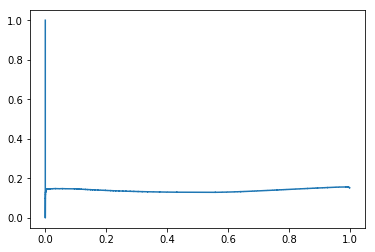

In [40]:
# precision-recall curve
y_scores = -probas_gmm
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)

# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
auroc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

In [41]:
# visualization
probas_patches_gmm = np.reshape(probas_gmm, np.shape(data_test.gt_patches))
probas_patches_gmm -= np.min(probas_patches_gmm)
probas_patches_gmm /= np.max(probas_patches_gmm)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(data_test.imgs)):
    acc_im_gmm = convert_patches_to_image(data_test.imgs, probas_patches_gmm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_gmm = exposure.equalize_hist(acc_im_gmm)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_gmm, f_name, dpi=my_dpi)


# SVM

In [42]:
act_train_svm = preprocessing.scale(act_train)
act_train_all_svm = preprocessing.scale(act_train_all)
act_val_all_svm = preprocessing.scale(act_val_all)
act_test_svm = preprocessing.scale(act_test)

In [43]:
# parameter search

if paramsearch:
    tuned_parameters = [{'kernel': ['rbf'],
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'degree':[1]
                         },
                        {'kernel': ['poly'],
                         'degree': np.arange(1, 4),
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'max_iter': [10000]}]

    # do parameter search
    ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, act_train_svm, act_train_all,
                             pred_f_tr.flatten(), scorer_roc_probas_svm, n_iter=5,
                             verbosity=11, n_jobs=-1, subsample_train=.0001, subsample_test=.001)
    ps_svm.fit()
    best_params_svm = ps_svm.best_params
else:
    best_params_svm = {'kernel': df_ps.loc[str(names[class_to_remove])]['oc-svm_k'], 
                       'degree': df_ps.loc[str(names[class_to_remove])]['oc-svm_deg'], 
                       'nu': df_ps.loc[str(names[class_to_remove])]['oc_svm_nu'],
                       'max_iter':10000}
    
print(best_params_svm)

Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.0001}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.001}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.01}
Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.1}


[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:   21.3s


Trying parameters: {'degree': 1, 'kernel': 'rbf', 'nu': 0.5}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=40)]: Done   3 out of  20 | elapsed:   25.2s remaining:  2.4min


Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}


[Parallel(n_jobs=40)]: Done   5 out of  20 | elapsed:   29.8s remaining:  1.5min


Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}
Trying parameters: {'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done   7 out of  20 | elapsed:   32.8s remaining:  1.0min


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


[Parallel(n_jobs=40)]: Done   9 out of  20 | elapsed:   37.5s remaining:   45.9s


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


[Parallel(n_jobs=40)]: Done  11 out of  20 | elapsed:   41.0s remaining:   33.5s


Trying parameters: {'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.0001}


[Parallel(n_jobs=40)]: Done  13 out of  20 | elapsed:   45.0s remaining:   24.2s


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.01}
Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.1}


[Parallel(n_jobs=40)]: Done  15 out of  20 | elapsed:   49.2s remaining:   16.4s


Trying parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=40)]: Done  17 out of  20 | elapsed:   51.6s remaining:    9.1s
[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:   59.9s finished


{'degree': 2, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.001}


In [44]:
# Fit SVM
clf_svm = svm.OneClassSVM(**best_params_svm)
clf_svm.fit(draw_subsamples(act_train_svm, .001))

OneClassSVM(cache_size=200, coef0=0.0, degree=2, gamma='auto', kernel='poly',
      max_iter=10000, nu=0.001, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [45]:
# predict
probas_svm = clf_svm.decision_function(act_test_svm[dataset_subset_indices])
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [46]:
probas_svm = clf_svm.decision_function(act_test_svm)
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [47]:
# metrics

y_scores = -probas_svm[:]
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
auroc_svm = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_svm, pr_auc_svm))

AUROC: 0.49, PR AUC: 0.14


In [48]:
# visualization
probas_patches_svm = np.reshape(probas_svm, np.shape(data_test.gt_patches))

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(data_test.imgs)):
    acc_im_svm = convert_patches_to_image(data_test.imgs, probas_patches_svm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_svm = exposure.equalize_hist(acc_im_svm)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_svm_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_svm, f_name, dpi=my_dpi)

#### Visualize Kernels

In [49]:
subset_ind = get_balanced_subset_indices(data_train.gt_patches.flatten(), classes_to_keep, pts_per_class=150)

subsample = act_train_all_svm[np.concatenate(subset_ind)]

In [50]:
# RBF
K = RBF()
K_X = K.__call__(subsample)
K_X = exposure.equalize_hist(K_X)
f_name = "../Figures/Zurich/Kernels/Kernel_RBF_wo_cl_" + str(class_to_remove) + ".jpg" 
export_figure_matplotlib(K_X, f_name, dpi=my_dpi)

# polynomial
for deg in [1, 2, 3]:
    K_X = metrics.pairwise.polynomial_kernel(subsample, degree=deg)
    # contrast stretching
    p2, p98 = np.percentile(K_X, (2, 98))
    K_X = exposure.rescale_intensity(K_X, in_range=(p2, p98))

    f_name = "../Figures/Zurich/Kernels/Kernel_poly_wo_cl_" + str(class_to_remove) + "_deg_" + str(deg) + ".jpg"
    export_figure_matplotlib(K_X, f_name, dpi=my_dpi)

## Density Forest

In [51]:
# Create DensityForest instance
clf_df = DensityForest(max_depth=2, min_subset=.1, n_trees=100,
                       subsample_pct=.1, n_jobs=-1, verbose=10,
                       ig_improvement=.4)

In [52]:
# fit to training data
clf_df.fit(tsne_train)

Number of points on which to train each tree: 140
Minimum number of points in each leaf: 14


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=40)]: Done  32 out of 100 | elapsed:    1.1s remaining:    2.3s
[Parallel(n_jobs=40)]: Done  43 out of 100 | elapsed:    1.3s remaining:    1.7s
[Parallel(n_jobs=40)]: Done  54 out of 100 | elapsed:    1.5s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  65 out of 100 | elapsed:    1.6s remaining:    0.9s
[Parallel(n_jobs=40)]: Done  76 out of 100 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=40)]: Done  87 out of 100 | elapsed:    1.8s remaining:    0.3s


Number of created root nodes: 99
Mean number of clusters created per tree: 4


[Parallel(n_jobs=40)]: Done  98 out of 100 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    1.8s finished


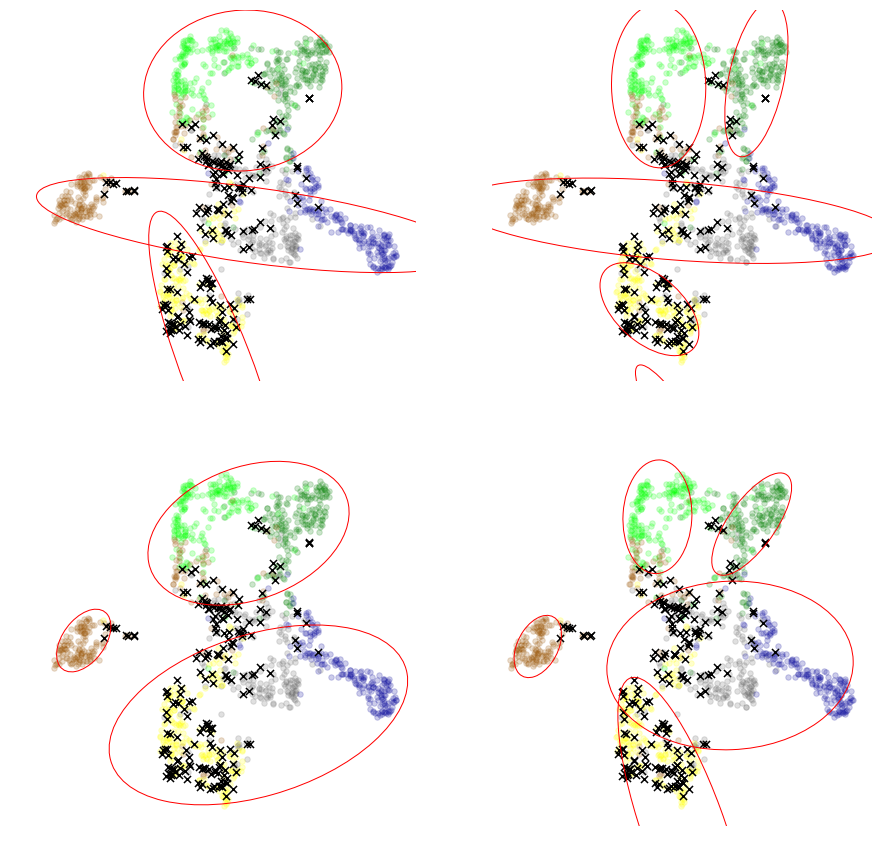

In [53]:
# Show ellipses on plot
_, axes = plt.subplots(2, 2, figsize=(15, 15)) 
for i in range(4):
    plot_pts_2d(tsne_all, tsne_y, axes[int(i/2)][np.mod(i, 2)], classes_to_keep, 
                colors, class_to_remove=class_to_remove)
    axes[int(i/2)][np.mod(i, 2)].set_axis_off()
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(axes[int(i / 2)][np.mod(i, 2)], means, covs)

In [54]:
# export some ellipses for GIF

for i in range(10):
    _, ax = plt.subplots(1, 1, figsize=(8, 8)) 
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors, 
                class_to_remove=class_to_remove, names=names)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(ax, means, covs)
    plt.axis('off')
    plt.savefig("../Figures/Zurich/GIF/TSNE_act_wo_cl" + str(class_to_remove) + "_"+str(i)+".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

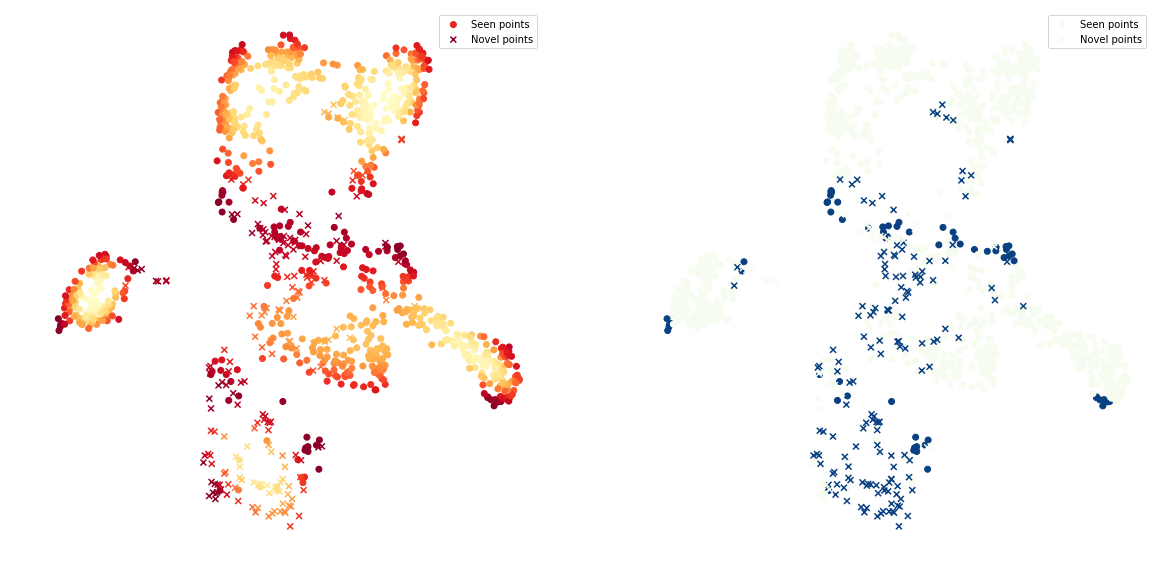

In [55]:
# plot

# get probabilities for all images
probas_df = np.log(clf_df.predict(tsne_all))

# indices of correctly / wrongly predicted points
pred_f = pred_f_te.flatten()[dataset_subset_indices]
pred_t = pred_t_te.flatten()[dataset_subset_indices]

# plot colors
probas_df_c = imgs_stretch_eq(probas_df[np.newaxis, ..., np.newaxis])[0, ..., 0]
colors_plt = plt.cm.YlOrRd(1 - probas_df_c)[..., :3]

# threshold for second plot
c_thresh_t = plt.cm.GnBu((probas_df < np.sort(probas_df)[tsne_pts_per_class])*255)[:, :3]

c_thresh_f = plt.cm.GnBu((probas_df > np.sort(probas_df)[tsne_pts_per_class])*255)[:, :3]

# plot correctly predicted points (o marker)
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 
axes[0].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t])
axes[1].scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=c_thresh_t[pred_t])

# plot incorrectly predicted points (x marker)
axes[0].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], marker='x')
axes[1].scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=c_thresh_f[pred_f], marker='x')
[axes[i].legend(['Seen points', 'Novel points']) for i in range(2)]
[axes[i].set_axis_off() for i in range(2)]
extent = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("../Figures/Zurich/GIF/probas.pdf", bbox_inches=extent, pad_inches=0)

### Fit on real data

In [56]:
# parameter search
default_params = {'n_trees': 10, 'n_max_dim': 0, 'n_jobs': -1, 
                  'verbose': 0, 'subsample_pct': .0002, 'min_subset': 1e-3}

if paramsearch:
    """search for best hyperparameters"""
    tuned_params = [{'max_depth': [1, 2, 3],
                     'ig_improvement': [-np.infty, 0, .4, .7]
                    }]

    # do parameter search
    ps_df = ParameterSearch(DensityForest, tuned_params, act_train, act_train_all,
                            pred_f_tr.flatten(), scorer_roc_probas_df,
                            n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, 
                            subsample_test=.001, default_params=default_params)

    print("Testing %i combinations %i times" % (len(ps_df.combinations), ps_df.n_iter))
    print(ps_df.combinations)
    ps_df.fit()
    print(ps_df.best_params)
    
    # Create DensityForest instance
    best_params_df = ps_df.best_params
    
else:
    """use previously found hyperparameters"""
    best_params_df = {'max_depth': df_ps.loc[str(names[class_to_remove])]['df_depth'],
                      'ig_improvement': df_ps.loc[str(names[class_to_remove])]['df_min_ig']}
    
    
print(best_params_df)
default_params['verbose'] = 1
default_params['batch_size'] = 10000

Testing 12 combinations 3 times
[{'ig_improvement': -inf, 'max_depth': 1}
 {'ig_improvement': -inf, 'max_depth': 2}
 {'ig_improvement': -inf, 'max_depth': 3}
 {'ig_improvement': 0, 'max_depth': 1}
 {'ig_improvement': 0, 'max_depth': 2}
 {'ig_improvement': 0, 'max_depth': 3}
 {'ig_improvement': 0.4, 'max_depth': 1}
 {'ig_improvement': 0.4, 'max_depth': 2}
 {'ig_improvement': 0.4, 'max_depth': 3}
 {'ig_improvement': 0.7, 'max_depth': 1}
 {'ig_improvement': 0.7, 'max_depth': 2}
 {'ig_improvement': 0.7, 'max_depth': 3}]
Trying parameters: {'ig_improvement': -inf, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.2s remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.2min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  8.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.8min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.8min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.7, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
{'ig_improvement': -inf, 'max_depth': 1}
{'ig_improvement': -inf, 'max_depth': 1}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 14.1min finished


In [57]:
# fit DF with best found parameters
clf_df = DensityForest(**best_params_df, **default_params)
clf_df.fit(act_train)

# get probabilities for all images
probas_df = clf_df.predict(act_test)

Number of points on which to train each tree: 1200
Minimum number of points in each leaf: 1


[Parallel(n_jobs=40)]: Done   8 out of  10 | elapsed:    5.4s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:    5.5s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 4
Total steps: 485
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   18.5s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   53.9s
[Parallel(n_jobs=40)]: Done 484 out of 484 | elapsed:  1.0min finished


### Post-Treatment

In [58]:
# reshape probas to (n_patches, patch_size, patch_size)
probas_patches_df = np.reshape(probas_df, np.shape(data_test.gt_patches))

# transformations
probas_patches_df -= np.nanmin(probas_patches_df)
probas_patches_df /= np.nanmax(probas_patches_df)

### Metrics

In [59]:
# metrics
y_scores = -probas_df

# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

AUROC: 0.69, PR AUC: 0.25


In [60]:
# visualization
probas_patches_df = np.reshape(probas_df, np.shape(data_test.gt_patches))
probas_patches_df -= np.min(probas_patches_df)
probas_patches_df /= np.max(probas_patches_df)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(data_test.imgs)):
    acc_im_df = convert_patches_to_image(data_test.imgs, probas_patches_df[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_df = exposure.equalize_hist(acc_im_df)
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_df_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_df, f_name, dpi=my_dpi)

## Plot Results

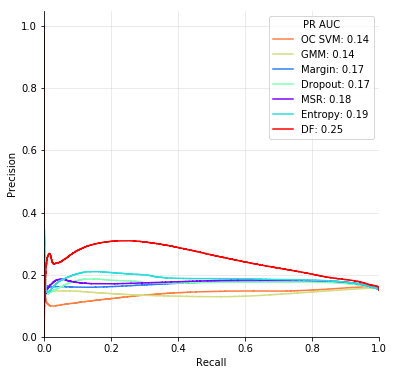

In [61]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, 
              precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/Zurich/Metrics/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", 
            bbox_inches='tight', pad_inches=0)

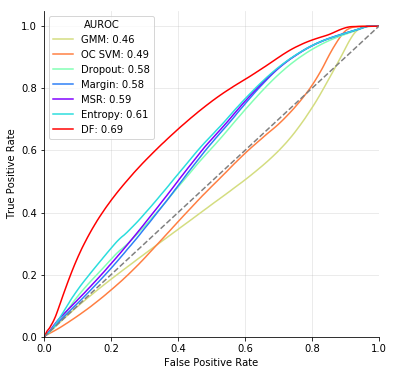

In [62]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.plot(fprs[i], tprs[i], c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/Zurich/Metrics/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", 
            bbox_inches='tight', pad_inches=0)

In [63]:
# write best hyperparameters to CSV file
best_params = {'gmm_n_components': best_params_gmm['n_components'], 
               'oc-svm_k': best_params_svm['kernel'], 
               'oc-svm_deg': best_params_svm['degree'], 
               'oc_svm_nu': best_params_svm['nu'], 
               'df_depth': best_params_df['max_depth'], 
               'df_min_ig': best_params_df['ig_improvement']}

In [64]:
# write results to CSV files
# hyperparameters
df_ps = pd.read_csv('models_out/hyperparams.csv', index_col=0)
df2 = pd.DataFrame(best_params, index=[str(names[class_to_remove])])
df_ps = df_ps.append(df2)
df_ps = df_ps[~df_ps.index.duplicated(keep='last')]  # avoid duplicates
df_ps.to_csv('models_out/hyperparams.csv')

# AUROC
df_auroc = pd.read_csv('models_out/auroc_all.csv', index_col=0)
df2 = pd.DataFrame({str(names[class_to_remove]): scores_auc}, index = names_methods).T
df_auroc = df_auroc.append(df2)
df_auroc = df_auroc[~df_auroc.index.duplicated(keep='last')]  # avoid duplicates
df_auroc.to_csv('models_out/auroc_all.csv')


# PR AUC
df_aucpr = pd.read_csv('models_out/aucpr_all.csv', index_col=0)
df2 = pd.DataFrame({str(names[class_to_remove]): scores_pr}, index = names_methods).T
df_aucpr = df_aucpr.append(df2)
df_aucpr = df_aucpr[~df_aucpr.index.duplicated(keep='last')]  # avoid duplicates
df_aucpr.to_csv('models_out/aucpr_all.csv')

In [65]:
# load auroc df with previously saved results
df_auroc = pd.read_csv('models_out/auroc_all.csv', index_col=0)

In [66]:
# reorder by class names
df_auroc = df_auroc.reindex(names[1:])
df_auroc.to_csv('models_out/auroc_all.csv')

In [67]:
# show latex table of AUROC metrics for all methods
print(df_auroc.round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &   MSR &  Margin &  Entropy &  Dropout &   GMM &  OC SVM &    DF \\
\midrule
Roads          &  0.59 &    0.58 &     0.61 &     0.58 &  0.46 &    0.49 &  0.69 \\
Buildings      &  0.65 &    0.65 &     0.64 &     0.64 &  0.66 &    0.62 &  0.64 \\
Trees          &  0.74 &    0.73 &     0.74 &     0.74 &  0.54 &    0.81 &  0.63 \\
Grass          &  0.38 &    0.38 &     0.39 &     0.39 &  0.67 &    0.76 &  0.51 \\
Bare Soil      &  0.67 &    0.69 &     0.61 &     0.57 &  0.67 &    0.60 &  0.51 \\
Water          &  0.60 &    0.61 &     0.60 &     0.59 &  0.64 &    0.45 &  0.63 \\
Railways       &  0.56 &    0.59 &     0.53 &     0.54 &  0.59 &    0.43 &  0.42 \\
Swimming Pools &  0.25 &    0.27 &     0.22 &     0.27 &  0.36 &    0.98 &  0.99 \\
\bottomrule
\end{tabular}



In [68]:
# show best method for each left-out class
df_auroc.T.idxmax()

Roads                 DF
Buildings            GMM
Trees             OC SVM
Grass             OC SVM
Bare Soil         Margin
Water                GMM
Railways          Margin
Swimming Pools        DF
dtype: object

In [69]:
# show mean aourc for each method
df_auroc.mean().round(2)

MSR        0.56
Margin     0.56
Entropy    0.54
Dropout    0.54
GMM        0.57
OC SVM     0.64
DF         0.63
dtype: float64

# Interesting Objects

In [70]:
import matplotlib.patches as patches

In [71]:
my_dpi = 128

In [72]:
def export_particularity(dataset, img_idx, x, y, width, height, confs_patches=None, names=None, dir_out=None, idx=0):
    """
    export detail view of interesting image: image with blue rectangle, cropped region, cropped GT, cropped conf images
    """
    class_to_remove = dataset.class_to_remove
    im = dataset.imgs[img_idx][..., :3]
    max_x = np.mod(im.shape[0], 32)
    max_y = np.mod(im.shape[1], 32)
    im = im[:-max_x, :-max_y]
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='b', alpha=.5)
    f_name = dir_out+ 'im_' + str(img_idx) + '_obj_' + str(idx) + '_im.jpg'
    export_figure_matplotlib(im, dpi=my_dpi, rect=rect, f_name=f_name)
    plt.close()
    
    rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='None')
    im_gt = gt_label_to_color(dataset.gt[img_idx], colors)*255
    max_x = np.mod(im_gt.shape[0], 32)
    max_y = np.mod(im_gt.shape[1], 32)
    im_gt = im_gt[:-max_x, :-max_y]
    f_name = dir_out+ 'im_' + str(img_idx) + '_obj_' + str(idx) + '_gt.jpg'
    export_figure_matplotlib(im_gt, dpi=my_dpi, rect=rect, f_name=f_name)
    plt.close()

    if confs_patches is not None:
        for idx_conf,conf_patches in enumerate(confs_patches):
            conf_im = convert_patches_to_image(dataset.imgs, conf_patches[..., np.newaxis], img_idx, 64, 64, 0)
            conf_im = imgs_stretch_eq([conf_im])[0]
                    
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='b', facecolor='b', alpha=.3)
            f_name = dir_out+ 'im_' + str(img_idx) + '_obj_' + str(idx) + '_' + names[idx_conf] + '_wo_cl_'+ str(class_to_remove) + '.jpg'
            export_figure_matplotlib(conf_im, dpi=my_dpi, rect=rect, f_name=f_name)
            plt.close()

In [73]:
dir_out = '../Figures/Zurich/Detail/im3/'
confs_patches = [probas_patches_msr, probas_patches_df] 
names_confs_patches = ['msr', 'df']
export_particularity(data_test, 3, 800, 320, 400, 300, dir_out=dir_out, confs_patches=confs_patches, names=names_confs_patches)